In [81]:
# Utility
import math

def abs_vec(vec: list[float]) -> float:
    return math.sqrt(vec[0]**2 + vec[1]**2)

def norm_vec(vec: list[float]) -> list[float]:
    if vec == [0, 0]:
        return [0, 0]
    a: float = abs_vec(vec)
    return [vec[0] / a, vec[1] / a]

def mult_vec_scal(vec: list[float], mult: float) -> list[float]:
    return [vec[0] * mult, vec[1] * mult]

def add_vec(vec1: list[float], vec2: list[float]) -> list[float]:
    return [vec1[0] + vec2[0], vec1[1] + vec2[1]]


In [82]:
SJUNKANDE_KULA = True
dts: list[float] = [0.1, 0.05, 0.01, 0.001, 0.0001] # s
y_cutoff: float = -100

In [83]:
# KASTRÖRELSE

mass: float = 0.0027 # kg
air_density: float = 1.2 # kg/m^3
diameter: float = 0.04 # m
drag_coeff: float = 0.47 # För sfär 0.47
k: float = 1/2 * air_density * drag_coeff * (diameter/2)**2 * math.pi
g: float = 9.82 # m/s^2

print(k)

v_0_abs: float = 40
alpha_0_deg: float = 35
alpha_0: float = math.radians(alpha_0_deg)

p_0: list[float] = [0,0]
v_0: list[float] = [v_0_abs * math.cos(alpha_0), v_0_abs * math.sin(alpha_0)]

def a_calc(v: list[float], p: list[float]) -> list[float]:
    return add_vec(mult_vec_scal(norm_vec(v), -(k/mass) * abs_vec(v)**2), [0,-g])

0.00035437165132492864


In [84]:
# SJUNKANDE KULA

if SJUNKANDE_KULA:
    sphere_density: float = 7870 # kg/m^3 (järn)
    fluid_density: float = 1420 # kg/m^3
    diameter: float = 0.02 # m
    V: float = 4/3 * math.pi * (diameter/2)**3
    mass: float = sphere_density * V # kg
    viscous_drag_coeff: float = 10 # Dynamic drag
    r: float = 90 * (diameter/2)
    g: float = 9.82 # m/s^2

    p_0: list[float] = [0, 0]
    v_0: list[float] = [0, 0]

    def a_calc(v: list[float], p: list[float]) -> list[float]:
        return add_vec(mult_vec_scal(norm_vec(v), -r * abs_vec(v)), [0, -g + fluid_density*V*g])

In [85]:
# LOGIK

t: float = 0

p: list[float] = p_0
v: list[float] = v_0

p_lists: list[list[list[float]]] = []

for dt in dts:
    p_list: list[list[float]] = []
    p = p_0
    v = v_0
    t = 0
    p_list.append(p)
    while t < 10:
        a: list[float] = a_calc(v, p)
        v = add_vec(v, mult_vec_scal(a, dt))
        p = add_vec(p, mult_vec_scal(v, dt))

        p_list.append(p)

        t += dt
    p_lists.append(p_list)

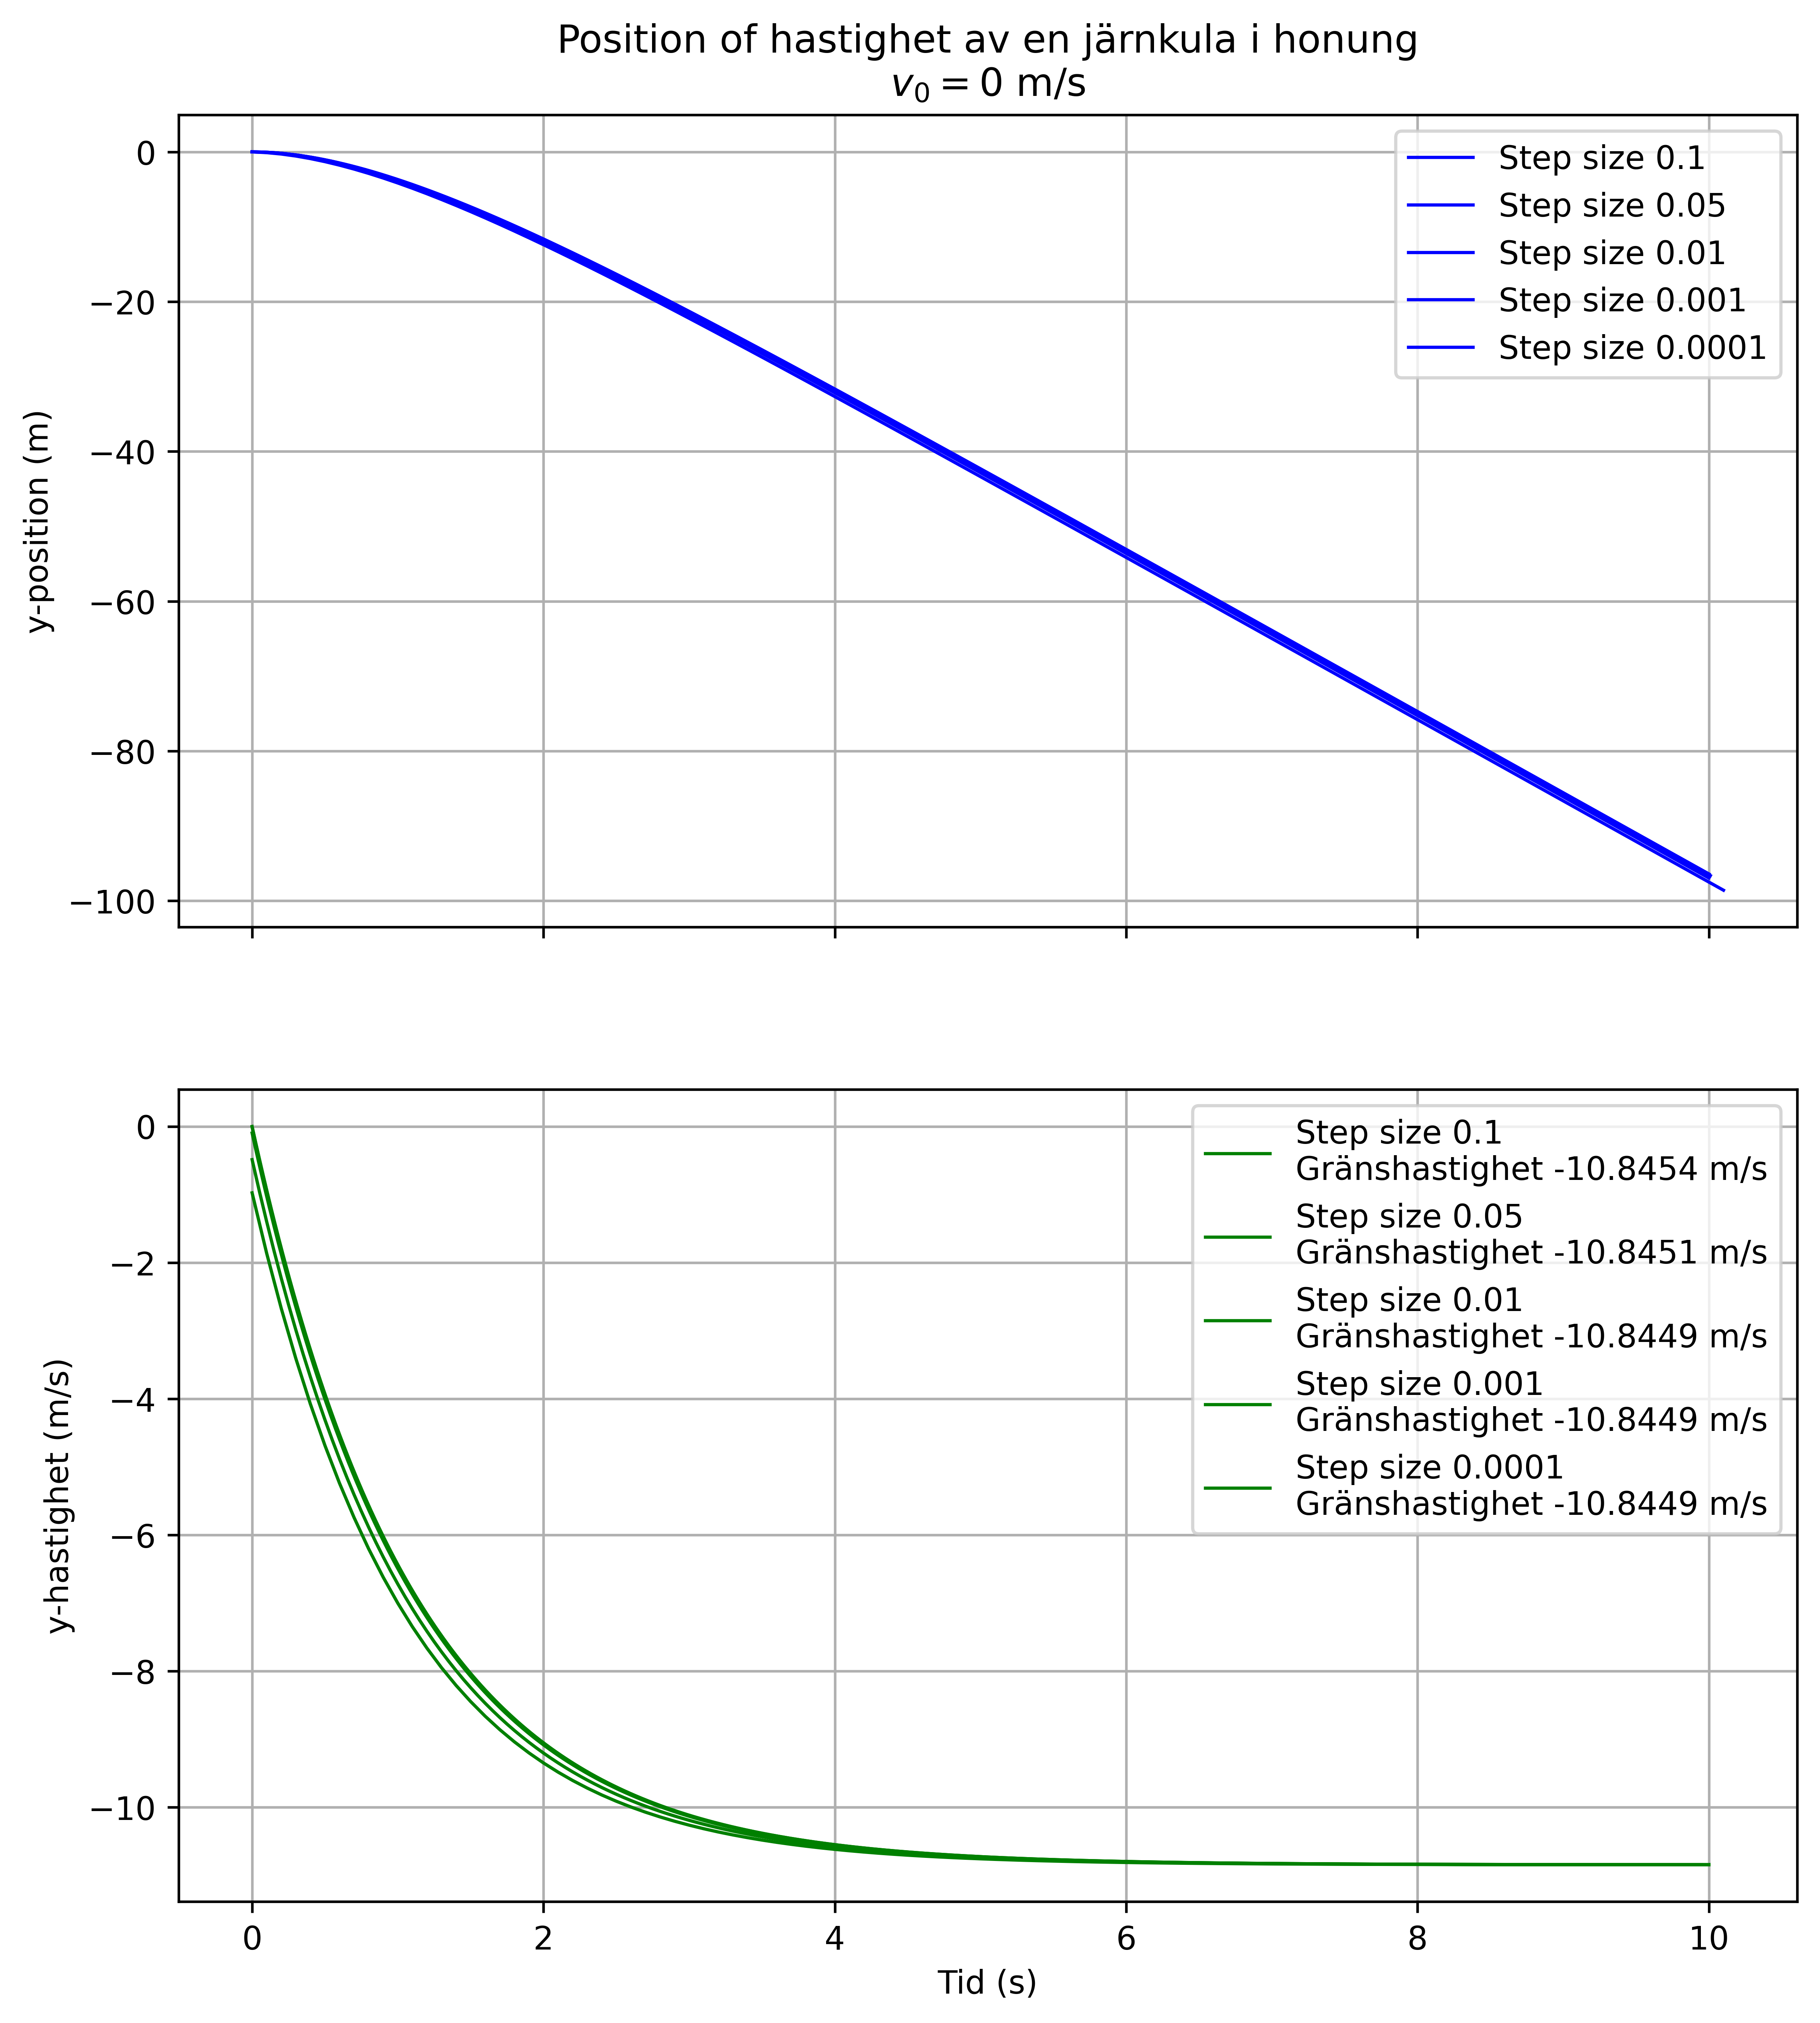

In [86]:
import matplotlib.pyplot as plt
import numpy as np

# Create the figure with two subplots
fig, axs = plt.subplots(2, 1, figsize=(9, 10), dpi=600, sharex=True)

legend_entries_position = []  # Store legend labels for position
legend_entries_velocity = []  # Store legend labels for velocity

# Iterate over each list of points and plot them
for i, p_list in enumerate(p_lists):
    p_ndarray = np.array(p_list)  # Convert to NumPy array
    
    # Apply y cutoff
    filtered_points = p_ndarray[p_ndarray[:, 1] >= y_cutoff]  # Keep only points where y >= y_cutoff
    
    if filtered_points.size == 0:  # Skip empty lists after filtering
        continue
    
    x_coords, y_coords = filtered_points[:, 0], filtered_points[:, 1]  # Extract x and y
    times = np.arange(len(y_coords)) * dts[i]  # Compute time values

    # Compute y velocity (finite difference method)
    v_y = np.diff(y_coords) / dts[i]  # First derivative of y
    v_times = times[:-1]  # Time points for velocity

    # Plot y position
    axs[0].plot(times, y_coords, linestyle='-', color='blue', linewidth=1, label=f"Step size {dts[i]}")
    
    # Plot y velocity
    axs[1].plot(v_times, v_y, linestyle='-', color='green', linewidth=1, label=f"Step size {dts[i]}")
    
    # Find x-axis crossings (where y changes sign) and y-max
    crossing_index = 0
    x_cross = 0
    y_max_index = np.argmax(y_coords)  # Index of max y

    for j in range(len(y_coords) - 1):
        # Detect y = 0 crossing
        if y_coords[j] * y_coords[j + 1] < 0:  
            x_cross = x_coords[j] - (y_coords[j] * (x_coords[j + 1] - x_coords[j]) / (y_coords[j + 1] - y_coords[j]))
            crossing_index = j  # Store crossing index
    
    # Create legend entries
    if not SJUNKANDE_KULA and crossing_index and x_cross != 0:
        legend_entry = f"Step size {dts[i]}\nMax y = {y_coords[y_max_index]:.4f} m at {y_max_index * dts[i]:.4f} s\ny = 0 at {crossing_index * dts[i]:.4f} s & x = {x_cross:.3f} m"
    else:
        legend_entry = f"Step size {dts[i]}"
    
    legend_entries_position.append(legend_entry)
    legend_entries_velocity.append(f"Step size {dts[i]}\nGränshastighet {v_y[-1]:.4f} m/s")

# Labels and titles
axs[0].set_ylabel("y-position (m)")
axs[0].set_title(f"Position of hastighet av en järnkula i honung\n$v_0 = {v_0[1]}$ m/s")
axs[0].legend(legend_entries_position, loc="best")
axs[0].grid(True)

axs[1].set_xlabel("Tid (s)")
axs[1].set_ylabel("y-hastighet (m/s)")
axs[1].legend(legend_entries_velocity, loc="best")
axs[1].grid(True)

# Show the plot
plt.show()
